In [20]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
# define dimensionality of the setting
d = 10

# Create high-dimensional XOR

In [151]:
#create two perpendicular vectors that define the two planes separating the space into 4 quadrants
planeVec1 = np.random.rand(d)
planeVec1 /= np.linalg.norm(planeVec1)  #normalize
planeVec2 = np.random.rand(d)
planeVec2 -= planeVec2.dot(planeVec1) * planeVec1       #make it orthogonal to planeVec1
planeVec2 /= np.linalg.norm(planeVec2)  #normalize

scale = 10.0
Sigma_scale = 2.0

np.random.seed(17)

#create 4 mean vectors, one in each quadrant
mu1 = np.random.rand(d)*scale
while not mu1.dot(planeVec1) > 0 and not mu1.dot(planeVec2) > 0:
    mu1 = np.random.rand(d)
    
mu2 = np.random.rand(d)*scale
while not mu2.dot(planeVec1) > 0 and not mu2.dot(planeVec2) < 0:
    mu2 = np.random.rand(d)
    
mu3 = np.random.rand(d)*scale
while not mu3.dot(planeVec1) < 0 and not mu3.dot(planeVec2) > 0:
    mu3 = np.random.rand(d)
    
mu4 = np.random.rand(d)*scale
while not mu4.dot(planeVec1) < 0 and not mu4.dot(planeVec2) < 0:
    mu4 = np.random.rand(d)
    
#create 4 covariance matrices
m = d
A1 = np.random.rand(m,d)*Sigma_scale
Sigma1 = A1.T@A1

A2 = np.random.rand(m,d)*Sigma_scale
Sigma2 = A2.T@A2

A3 = np.random.rand(m,d)*Sigma_scale
Sigma3= A3.T@A3

A4 = np.random.rand(m,d)*Sigma_scale
Sigma4 = A4.T@A4

In [155]:
N = 100000

# sample N points, N/4 from each distribution
X1 = np.random.multivariate_normal(mu1,Sigma1, size=N//4)
Y1 = np.ones(N//4)
X2 = np.random.multivariate_normal(mu2,Sigma2, size=N//4)
Y2 = np.zeros(N//4)
X3 = np.random.multivariate_normal(mu3,Sigma3, size=N//4)
Y3 = np.ones(N//4)
X4 = np.random.multivariate_normal(mu4,Sigma4, size=N//4)
Y4 = np.zeros(N//4)

# Visualize the data using PCA

In [156]:
X = np.vstack((X1,X2,X3,X4))
Y = np.hstack((Y1,Y2,Y3,Y4))

print(X.shape, Y.shape)

(100000, 10) (100000,)


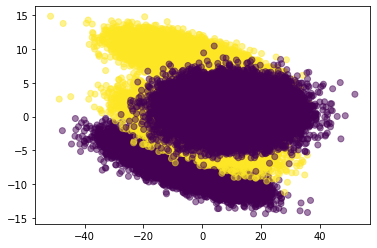

In [157]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
plt.scatter(X2D[:,0],X2D[:,1], c=Y, alpha=0.5)

# Can we successfully learn this dataset?

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train, X_param, Y_train, Y_param = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

paramsToTest = {DecisionTreeClassifier : {'max_depth' : range(1,10), 'min_samples_leaf' : [1,5,10,20,50,100]}, 
                LogisticRegression : {'C' : [2**i for i in range(-5,5)]}, 
                SVC : {'kernel' : ['linear','rbf'], 'C' : [2**i for i in range(-5,5)], 'gamma' : ['scale','auto'] + [2**i for i in range(-5,5)]}}
optParameters = {}
results = {}

for classifier in [DecisionTreeClassifier, LogisticRegression, SVC]:
    clfGridSearch = GridSearchCV(classifier(), paramsToTest[classifier])
    clfGridSearch.fit(X_param, Y_param)
    optParams = clfGridSearch.best_params_
    print("Optimal parameters of ",classifier, "  =  ", optParams )
    
    optParameters[classifier] = optParams
    
    clf = classifier(**optParams)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    ACC = accuracy_score(Y_test, Y_pred)
    
    results[classifier] = ACC
    
print(results)

Optimal parameters of  <class 'sklearn.tree._classes.DecisionTreeClassifier'>   =   {'max_depth': 9, 'min_samples_leaf': 1}
Optimal parameters of  <class 'sklearn.linear_model._logistic.LogisticRegression'>   =   {'C': 0.5}
Optimal parameters of  <class 'sklearn.svm._classes.SVC'>   =   {'C': 8, 'gamma': 'scale', 'kernel': 'rbf'}
{<class 'sklearn.tree._classes.DecisionTreeClassifier'>: 0.9784545454545455, <class 'sklearn.linear_model._logistic.LogisticRegression'>: 0.8966060606060606, <class 'sklearn.svm._classes.SVC'>: 0.9999090909090909}


# Check some simple distributed learning

In [159]:
Xlocal1 = np.vstack((X1,X2))
Ylocal1 = np.hstack((Y1,Y2))
Xlocal1, Xlocal1_shared, Ylocal1, Ylocal1_shared = train_test_split(Xlocal1, Ylocal1, test_size=0.2, random_state=42)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(Xlocal1, Ylocal1, test_size=0.33, random_state=42)

Xlocal2 = np.vstack((X3,X4))
Ylocal2 = np.hstack((Y3,Y4))
Xlocal2, Xlocal2_shared, Ylocal2, Ylocal2_shared = train_test_split(Xlocal2, Ylocal2, test_size=0.2, random_state=42)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(Xlocal2, Ylocal2, test_size=0.33, random_state=42)

Xgloabl = np.vstack((Xlocal1_shared, Xlocal2_shared))
Yglobal = np.hstack((Ylocal1_shared, Ylocal2_shared))

Xglobal_test = np.vstack((X1_test, X2_test))
Yglobal_test = np.hstack((Y1_test, Y2_test))

In [160]:
#averaging at the end (only works for linear models):
clf1 = LogisticRegression(**optParameters[LogisticRegression])
clf1.fit(X1_train, Y1_train)
Y1_pred = clf1.predict(X1_test)
Y1global_pred = clf1.predict(Xglobal_test)

clf2 = LogisticRegression(**optParameters[LogisticRegression])
clf2.fit(X2_train, Y2_train)
Y2_pred = clf2.predict(X2_test)
Y2global_pred = clf2.predict(Xglobal_test)

clfAverage = LogisticRegression(**optParameters[LogisticRegression])
clfAverage.classes_ = clf1.classes_
clfAverage.coef_      = (clf1.coef_      + clf2.coef_)      / 2.0
clfAverage.intercept_ = (clf1.intercept_ + clf2.intercept_) / 2.0
Y1_pred_avg = clfAverage.predict(X1_test)
Y2_pred_avg = clfAverage.predict(X2_test)
Yglobal_pred_avg = clfAverage.predict(Xglobal_test)

In [161]:
ACC1_local  = accuracy_score(Y1_test, Y1_pred)
ACC1_global = accuracy_score(Yglobal_test, Y1global_pred)
ACC2_local  = accuracy_score(Y2_test, Y2_pred)
ACC2_global = accuracy_score(Yglobal_test, Y2global_pred)

ACCavg_local1 = accuracy_score(Y1_test, Y1_pred_avg)
ACCavg_local2 = accuracy_score(Y2_test, Y2_pred_avg)
ACCavg_global = accuracy_score(Yglobal_test, Yglobal_pred_avg)

averagingResults = [ACC1_local, ACC1_global, ACC2_local, ACC2_global, ACCavg_local1, ACCavg_local2, ACCavg_global]

# Apparently, federated learning through model averaging fails.

In [162]:
print("Accuracy of learner 1 on local test data: \t\t\t", ACC1_local)
print("Accuracy of learner 1 on global test data: \t\t\t", ACC1_global)
print("Accuracy of learner 2 on local test data: \t\t\t", ACC2_local)
print("Accuracy of learner 2 on global test data: \t\t\t", ACC2_global)
print("")
print("Accuracy of average learner on local test data of learner 1: \t", ACCavg_local1)
print("Accuracy of average learner on local test data of learner 2: \t", ACCavg_local2)
print("Accuracy of average learner on global test data : \t\t", ACCavg_global)

Accuracy of learner 1 on local test data: 			 1.0
Accuracy of learner 1 on global test data: 			 0.5620833333333334
Accuracy of learner 2 on local test data: 			 1.0
Accuracy of learner 2 on global test data: 			 0.7008333333333333

Accuracy of average learner on local test data of learner 1: 	 0.49477272727272725
Accuracy of average learner on local test data of learner 2: 	 0.9817424242424242
Accuracy of average learner on global test data : 		 0.7382575757575758


# So, let's store the data in two seperate files, one for each "distribution"

In [163]:
import pandas as pd

Xlocal1_full = np.vstack((X1,X2))
Ylocal1_full = np.hstack((Y1,Y2))
Xlocal2_full = np.vstack((X3,X4))
Ylocal2_full = np.hstack((Y3,Y4))

df1 = pd.DataFrame(data = Xlocal1_full, index=list(range(Xlocal1_full.shape[0])), 
                   columns=['f'+str(i) for i in range(Xlocal1_full.shape[1])])
df1['label'] = Ylocal1_full

df2 = pd.DataFrame(data = Xlocal2_full, index=list(range(Xlocal2_full.shape[0])), 
                   columns=['f'+str(i) for i in range(Xlocal2_full.shape[1])])
df2['label'] = Ylocal2_full

df1.to_csv("data1.csv")
df2.to_csv("data2.csv")

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,label
0,5.784437,10.070137,0.414587,2.032776,7.650668,6.255313,7.008760,9.794011,6.952835,3.265448,1.0
1,6.028169,11.210276,6.442680,6.781859,14.334356,13.597379,14.009256,14.603321,6.891203,5.332610,1.0
2,2.069850,2.362911,0.696489,-2.947998,3.665211,4.820490,1.818559,4.773809,-2.097398,2.245195,1.0
3,3.911170,8.430931,4.559676,5.765526,11.623351,11.946607,12.943584,8.192380,3.021643,5.184482,1.0
4,1.541574,0.742667,2.316802,1.014900,5.869577,7.715088,8.117264,2.854776,-2.514235,2.885686,1.0
